## Kaggle Climate Change Belief Challenge

Alta Saunders

# Aim

Develop a machine leraning model that can predict whether people belief in Climate Change based on tweets.

# Supplied Data sets

- train.csv (should be used to train data)
- test.csv (should be used to test data and excludes arrival times)
- example of submission

# Import and viewing of Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
df_train = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/train.csv')
df_test = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/test.csv')
df_sub = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/sample_submission.csv')

In [40]:
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [14]:
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\alta\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Preprocessing of data

In [156]:
import nltk
import re

View data to see how to best clean it and remove noise

To clean data we can remove the @.... strings, we can remove punctuation and make everything lower case.

In [154]:
pattern_tweets = r'(RT)|(@[A-Za-z0-9]+)'
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'



In [17]:
tweets = df_train['message']

In [18]:
tweets_clean = []

from string import punctuation
my_punctuation = punctuation.replace("'", "")

for x in tweets:
    new = ' '.join(re.sub(pattern_tweets," ",x).split())
    new1 = ' '.join(re.sub(pattern_url," ",new).split())
    new2 = new1.translate(str.maketrans("", "", my_punctuation))
    new3 = ' '.join(re.sub(r'[^a-zA-Z]', " ",new2).split())
   
    tweets_clean.append(new3)

There are non-english tweets in the training dataset, however there are very few non-english tweets in the test dataset. We do not want to train our model on non-englisg tokens> Lets remove all non-englisjh characters.

In [20]:
len(tweets_en)

15819

In [33]:
df_train['message'] = tweets_en

In [34]:
#make lower case
df_train['message'] = df_train['message'].str.lower()

# Remove non-English characters

There are non-english tweets in the training dataset, however there are very few non-english tweets in the test dataset. We do not want to train our model on non-englisg tokens> Lets remove all non-englisjh characters.

In [43]:
list_en = list(df_train['message'])

tweets_en = [list_en.index(x) for x in df_train['message'] if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+", x)] 

In [46]:
df_clean = df_train.iloc[tweets_en]

## Dealing with Imbalanced data

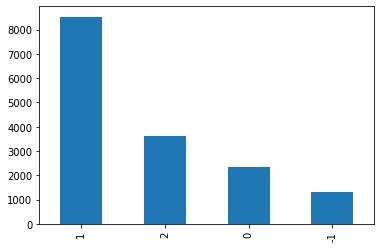

In [50]:
df_clean['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

There is a clear disparity in the distribution of the data (2,0,-1 are under represented). Everything needs to be equal before training.

In [55]:
# Indicies of each group
sentiment_0 = df_clean[df_clean.sentiment == 0]
sentiment_1 = df_clean[df_clean.sentiment == 1]
sentiment_2 = df_clean[df_clean.sentiment == 2]
sentiment_n1 = df_clean[df_clean.sentiment == -1]

In [56]:
# get length of majority sentiment
n_sentimentn1 = len(sentiment_n1)

In [57]:
from sklearn.utils import resample

In [58]:
# downsample majorityclass
sentiment_0_upsampled = resample(sentiment_0, replace=True, n_samples=n_sentimentn1, random_state=50) 
sentiment_1_upsampled = resample(sentiment_1, replace=True, n_samples=n_sentimentn1, random_state=50)
sentiment_2_upsampled = resample(sentiment_2, replace=True, n_samples=n_sentimentn1, random_state=50)
 

In [59]:
#create new upsampled dataframe
df_upsampled = pd.concat([sentiment_0_upsampled, sentiment_1_upsampled,sentiment_2_upsampled, sentiment_n1])

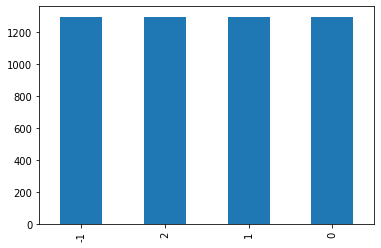

In [60]:
df_upsampled['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

## Tokenization

In [61]:
from nltk.tokenize import word_tokenize, TweetTokenizer

In [62]:
tokeniser = TweetTokenizer()
df_upsampled['tokens'] = df_upsampled['message'].apply(tokeniser.tokenize)

In [63]:
df_upsampled['tokens'].head()

11363    [team, d, if, global, warming, real, then, why...
10021    [you, re, quite, the, twat, magnet, don, t, ev...
12904    [if, you, re, watching, yes, yes, that, is, di...
14396    [if, i, had, a, nickel, for, every, time, i, t...
1325     [are, even, less, worried, about, russia, than...
Name: tokens, dtype: object

In [ ]:
df_upsampled.to_csv('C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_upsampled.csv', index = False)

## Vectorize

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
df_upsampled = pd.read_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_upsampled.csv')

In [109]:
vect = TfidfVectorizer(stop_words = 'english', ngram_range=(1,2),  max_features=5000)

In [110]:
X_tokens = vect.fit_transform(df_upsampled['message'])
df_tokens = pd.DataFrame(X_tokens.A, columns=vect.get_feature_names())

In [111]:
df_tokens.head()

,abandon,abortion,absolutely,accept,accepted,access,accord,according,account,accurate,...,young climate,young people,youth,yr,yr chain,yr researcher,zaman,zero,zero science,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
df_tokens.to_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_tokenstfidf.csv', index = False)

In [187]:
col_names_tokens = df_tokens.columns
col_names_tokens

Index(['abandon', 'abortion', 'absolutely', 'accept', 'accepted', 'access',
       'accord', 'according', 'account', 'accurate',
       ...
       'young climate', 'young people', 'youth', 'yr', 'yr chain',
       'yr researcher', 'zaman', 'zero', 'zero science', 'zone'],
      dtype='object', length=5000)

In [114]:
#add sentiment and to dataframe
y = df_upsampled['sentiment']

# Train model

## Split data into train and test data set

In [4]:
df_tokens = pd.read_csv('C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_tokens.csv')

In [115]:
df_tokens.shape

(5192, 5000)

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_tokens,y)

# Feature Selection

## Threshold variance

In [117]:
# Import the var thresh model and choose a threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

# Transform (i.e.: run selection on) the training data
X_train_vt = selector.fit_transform(X_train)

In [118]:
X_test_vt = selector.transform(X_test)

In [119]:
X_train_vt.shape

(3894, 4867)

In [120]:
X_test_vt.shape

(1298, 4867)

In [121]:
vt = X_train.loc[:, selector.fit(X_train).get_support()]

## K-best

In [122]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 113  175  409  516  783  969 1014 1077 1117 1152 1153 1159 1165 1171
 1278 1311 1312 1366 1485 1486 1542 1606 1613 1614 1690 1714 1741 1768
 1780 1781 1803 1808 1830 1838 1839 1875 1882 1910 1932 2002 2003 2036
 2054 2138 2192 2194 2202 2203 2264 2268 2322 2332 2350 2495 2510 2511
 2519 2541 2591 2625 2639 2687 2712 2756 2757 2779 2785 2800 2933 2973
 3136 3145 3146 3162 3175 3178 3256 3307 3330 3434 3447 3503 3534 3535
 3606 3607 3611 3623 3711 3712 3723 3730 3765 3773 3844 3918 3919 3941
 4034 4064 4161 4162 4221 4251 4268 4334 4337 4366 4376 4381 4460 4492
 4496 4497 4519 4520 4522 4529 4537 4544 4592 4611 4643 4671 4679 4686
 4784 4785 4794 4858 4915 4967 4974] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [123]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(X_test)

In [124]:
X_test_kbest.shape

(1298, 20)

In [125]:
X_train_kbest.shape

(3894, 20)

In [126]:
kbest = selector_kbest.get_support(indices=True)

In [127]:
kbest = X_train.iloc[:, kbest]

## Train model

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [129]:
#create models

lr = LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=1) 
kn = KNeighborsClassifier(5)
svc_linear = SVC(kernel="linear", C=0.05)
svc = SVC(gamma=1, C=2)
dtc = DecisionTreeClassifier(max_depth=10)
rfc = RandomForestClassifier(max_depth=10, n_estimators=10)
abc = AdaBoostClassifier()

In [130]:
#train model on train data
lr.fit(X_train, y_train)
kn.fit(X_train, y_train)
svc_linear.fit(X_train, y_train)
svc.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
abc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[LibLinear]

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [131]:
#predict on test data
lr_pred = lr.predict(X_test)
kn_pred = kn.predict(X_test)
svc_linear_pred = svc_linear.predict(X_test)
svc_pred =  svc.predict(X_test)
dtc_pred = dtc.predict(X_test)
rfc_pred = rfc.predict(X_test) 
abc_pred = abc.predict(X_test)

create svc models with variance selecting

In [132]:
svc_kbest = SVC(gamma=1, C=2)
svc_kbest = svc_kbest.fit(X_train_kbest, y_train)
svc_kbest_pred = svc_kbest.predict(X_test_kbest)

In [133]:
svc_vt = SVC(gamma=1, C=2)
svc_vt = svc_vt.fit(X_train_vt, y_train)
svc_vt_pred = svc_vt.predict(X_test_vt)

## Calculate metrics

### F1

In [134]:
from sklearn import metrics

In [135]:
lr_f1  = metrics.f1_score(y_test, lr_pred, average='micro')
kn_f1  = metrics.f1_score(y_test, kn_pred, average='micro')
svc_linear_f1  = metrics.f1_score(y_test, svc_linear_pred, average='micro')
svc_f1  = metrics.f1_score(y_test, svc_pred, average='micro')
dtc_f1  = metrics.f1_score(y_test, dtc_pred, average='micro')
rfc_f1  = metrics.f1_score(y_test, rfc_pred, average='micro')
abc_f1  = metrics.f1_score(y_test, abc_pred, average='micro')

In [136]:
print('lr: ', lr_f1)
print('kn: ', kn_f1)
print('svc_linear: ', svc_linear_f1)
print('svc: ', svc_f1)
print('dtc: ', dtc_f1)
print('rfc :', rfc_f1)
print('abc :', abc_f1)

lr:  0.3081664098613251
kn:  0.5169491525423728
svc_linear:  0.35439137134052384
svc:  0.6194144838212635
dtc:  0.42835130970724183
rfc : 0.4437596302003082
abc : 0.4406779661016949


In [137]:
svc_f1_vt  = metrics.f1_score(y_test, svc_vt_pred, average='micro')
svc_f1_kbest  = metrics.f1_score(y_test, svc_kbest_pred, average='micro')

In [138]:
print('vt: ', svc_f1_vt)
print('kbest: ', svc_f1_kbest)

vt:  0.6201848998459168
kbest:  0.4052388289676425


## Tune Hyper parameters

In [139]:
from sklearn.model_selection import GridSearchCV

Since SVC model did the best, we will start with the hyper parameter tuning for it

In [96]:
nfolds = 2

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {
    'C'     : Cs, 
    'gamma' : gammas
    }

grid_SVM = GridSearchCV(SVC(), param_grid, scoring='f1_micro', cv=nfolds)

In [ ]:
grid_SVM.best_params_

Now lets use to new hyperparamers and see if there is an improvement

In [140]:
svc_new = SVC(gamma=1, C=1)

In [144]:
svc_new.fit(X_train_vt, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [145]:
svc_new_pred =  svc_new.predict(X_test_vt)

In [146]:
svc_f1_new  = metrics.f1_score(y_test, svc_new_pred, average='micro')
print('svc_new: ', svc_f1_new)

svc_new:  0.615562403697997


Save model to be used later

In [147]:
import pickle

In [148]:
model_saved_path = 'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/svc_vt.pkl'

In [149]:
with open(model_saved_path, 'wb') as file: pickle.dump(svc_vt, file)

## Get submission dataframe

In [202]:
df_test = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/test.csv')
df_sub = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/sample_submission.csv')

In [203]:
tweets_test = df_test['message']

In [204]:
tweets_test_clean = []

from string import punctuation
my_punctuation = punctuation.replace("'", "")

for x in tweets_test:
    new = ' '.join(re.sub(pattern_tweets," ",x).split())
    new1 = ' '.join(re.sub(pattern_url," ",new).split())
    new2 = new1.translate(str.maketrans("", "", my_punctuation))
    new3 = ' '.join(re.sub(r'[^a-zA-Z]', " ",new2).split())
   
    tweets_test_clean.append(new3)


In [205]:
df_test['message'] = tweets_test_clean

In [206]:
#make lower case
df_test['message'] = df_test['message'].str.lower()

In [207]:
df_test_clean = df_test

In [208]:
from sklearn.feature_extraction.text import CountVectorizer
vect = TfidfVectorizer(stop_words = 'english', ngram_range=(1,2),  max_features=5000)

X_stem_test = vect.fit_transform(df_test_clean['message'])
df_stem_test = pd.DataFrame(X_stem_test.A, columns=vect.get_feature_names())

In [209]:
col_names_tokens

Index(['abandon', 'abortion', 'absolutely', 'accept', 'accepted', 'access',
       'accord', 'according', 'account', 'accurate',
       ...
       'young climate', 'young people', 'youth', 'yr', 'yr chain',
       'yr researcher', 'zaman', 'zero', 'zero science', 'zone'],
      dtype='object', length=5000)

In [210]:
name_list = []

for i in df_stem_test.columns:
    if i in col_names_tokens:
        name_list.append(i)

In [211]:
missing = []

for i in col_names_tokens:
    if i not in name_list:
        missing.append(i)

In [212]:
complete_word_list = name_list + missing

In [213]:
len(missing)

2766

In [214]:
len(name_list)

2234

In [215]:
len(complete_word_list)

5000

In [216]:
len(col_names_tokens)

5000

In [217]:
new_X = df_stem_test.reindex(columns = complete_word_list, fill_value=0)

In [218]:
len(new_X.columns)

5000

In [219]:
y_pred = svc.predict(new_X)

In [220]:
svc_final_df = pd.DataFrame()

svc_final_df['tweetid'] = df_test['tweetid']
svc_final_df['sentiment'] = y_pred

In [222]:
svc_final_df.to_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/svc_kaggle_sumbmission.csv', index = False)

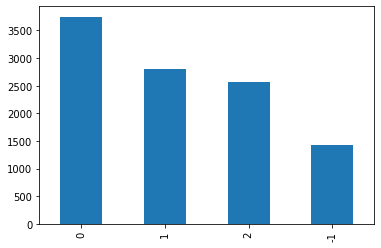

In [221]:
svc_final_df['sentiment'].value_counts().plot(kind = 'bar')
plt.show()